<a href="https://colab.research.google.com/github/jayy1809/Clothes-CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (3783/3783), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.preprocessing.image import load_img

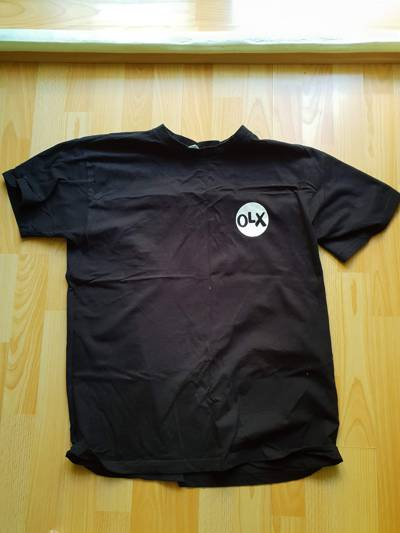

In [4]:
import os

path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
image = os.path.join(path,name)
load_img(image)

# OR

# fullname = path + '/' + name
# load_img(fullname)



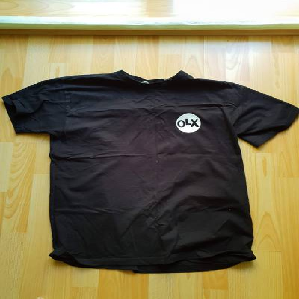

In [5]:
load_img(image, target_size=(299,299))
#target_size is used to resize the image

Here we will use a pre-trained NEURAL model which is Xception, it is relatively small model and has good performance

In [6]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [7]:
model = Xception(
    weights='imagenet',
    input_shape=(299,299,3)
)

91884032/91884032 [==============================] - 1s 0us/step


In [8]:
img = load_img(image,target_size=(299,299))

In [9]:
x = np.array(img)

In [10]:
x.shape

(299, 299, 3)

In [11]:
X = np.array([x])
X.shape

# as we have only 1 image it shows 1,299,299,3 | if we had batch of 10 images then we would have 10,299,299,3

(1, 299, 299, 3)

In [12]:
X = preprocess_input(X)

In [13]:
prediction = model.predict(X)


1/1 [==============================] - 3s 3s/step


In [14]:
prediction.shape

(1, 1000)

the array is quite large with 1000 classes, this Xception model predicts if an image belongs to one of those 1000 classes , so each element in the prediciton array is the probablity of belonging to one of these classes


In [15]:
prediction[0,:10]

array([0.00032371, 0.00015738, 0.00021349, 0.00015237, 0.00024763,
       0.00030504, 0.00032059, 0.0001475 , 0.00020362, 0.00014927],
      dtype=float32)

here we dont know this class names hence we have decode_predicitons function for that. which will give meaningful class names

In [16]:
decode_predictions(prediction)

35363/35363 [==============================] - 0s 0us/step


[[('n03595614', 'jersey', 0.681964),
  ('n02916936', 'bulletproof_vest', 0.038139928),
  ('n04370456', 'sweatshirt', 0.03432469),
  ('n03710637', 'maillot', 0.01135421),
  ('n04525038', 'velvet', 0.0018453539)]]

see here jersey has the probablity of 0.68196416 means high probablity it is a tsshirt , jersey which indeed it is

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [18]:
train_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

ImageDataGenerator function helps us with{

  1) Data Augmentation :ImageDataGenerator allows you to perform on-the-fly data augmentation by applying various transformations to the input images during training. These transformations may include rotation, width and height shifts, zooming, horizontal and vertical flipping, etc.
Augmenting the training data with variations of the original images helps the model learn more invariant features and improves its ability to generalize to new, unseen data.


  2) Normalization :The generator can also handle the normalization of pixel values in the input images. Normalization is essential to ensure that pixel values are within a specific range (e.g., between 0 and 1 or -1 and 1), which can enhance the convergence and stability of the training process.


  3)  Batching: ImageDataGenerator can generate batches of augmented images along with their corresponding labels. This is particularly useful when training deep learning models in a mini-batch fashion, where the model is updated based on a subset of the training data at each iteration.


  4)  Flow from Directory:
The generator can read images directly from a directory structure, where each subdirectory represents a different class. This is convenient for organizing datasets in a structured manner.

}

In [19]:
train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    target_size = (150,150),
    batch_size = 32
)

Found 3068 images belonging to 10 classes.


In [20]:
image_size = (150,150)
batch_size = 32

validation_gen = ImageDataGenerator(
 preprocessing_function=preprocess_input
)
val_ds = validation_gen.flow_from_directory(
 "clothing-dataset-small/validation",
 target_size=image_size,
 batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [21]:
base_model = Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150,150,3)
)

83683744/83683744 [==============================] - 1s 0us/step


In [22]:
base_model.trainable = False

We freeze the training because if we dont do this then our filters will be trained and already trained filters will be destroyed as we are doing transfer learning we are using convolutional layer which already has trained hence we freeze the model from training on weights

NOW we will build a classification model

In [23]:
inputs = keras.Input(shape=(150,150,3))
base = base_model(inputs, training=False)

pooling = keras.layers.GlobalAveragePooling2D()
vector = pooling(base)

outputs = keras.layers.Dense(10)(vector)
# Dense(10) means that in our hidden layer we have 10 neurons , we can also have activation function here,
# Dense(10, activation='ReLU')

model = keras.Model(inputs, outputs)

In [24]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate)

we are using Adam optimizer which will adjust the weights of Dense layer and then we have learning rate which is an hyperparameter

In [25]:
loss = keras.losses.CategoricalCrossentropy(from_logits = True)

# ALTERNATIVELY WE COULD HAVE DONE

# outputs = keras.layers.Dense(10, activation='softmax')(vector)
# loss = keras.losses.CategoricalCrossentropy()

# In this case, we explicitly tell the network to output probabilities: softmax is similar to
# sigmoid, but for multiple classes. Then the output is not “logits” anymore, so we can drop this
# parameter

here we have used CategoricalCrossentropy as our loss funciton becausde we have multiple classes in our classification

from_logits = True means that we are outputting unnormalized predicition score instead of probablities, logits are raw values produced by last layer of model before applying a softmax activation

Setting from_logits=True means that the loss function will internally apply the softmax activation to the model's logits before calculating the cross-entropy.

In [26]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = ["accuracy"]
)

In [27]:
model_history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 18s 131ms/step - loss: 1.2461 - accuracy: 0.6741 - val_loss: 0.7751 - val_accuracy: 0.8006
Epoch 2/10
96/96 [==============================] - 8s 86ms/step - loss: 0.5896 - accuracy: 0.8119 - val_loss: 0.8593 - val_accuracy: 0.7771
Epoch 3/10
96/96 [==============================] - 8s 82ms/step - loss: 0.4040 - accuracy: 0.8703 - val_loss: 0.7885 - val_accuracy: 0.8065
Epoch 4/10
96/96 [==============================] - 9s 90ms/step - loss: 0.2360 - accuracy: 0.9172 - val_loss: 0.8242 - val_accuracy: 0.8123
Epoch 5/10
96/96 [==============================] - 9s 89ms/step - loss: 0.1537 - accuracy: 0.9433 - val_loss: 0.8870 - val_accuracy: 0.8094
Epoch 6/10
96/96 [==============================] - 8s 81ms/step - loss: 0.1373 - accuracy: 0.9505 - val_loss: 1.0125 - val_accuracy: 0.7977
Epoch 7/10
96/96 [==============================] - 9s 89ms/step - loss: 0.1074 - accuracy: 0.9615 - val_loss: 1.0616 - val_accuracy: 0.8035
Epoch 8/10


In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20881970 (79.66 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


At some point, it can learn the dataset so well that it starts overfitting. To know when it
happens, we need to monitor the performance of our model on the validation dataset. That’s
why we specify the validation_data parameter.

-------------------------------------------------------------------------

The accuracy on training and validation datasets. We should monitor the accuracy on
the validation set to make sure the model doesn’t start overfitting. For example, if the
validation accuracy decreases for multiple epochs, it’s a sign of overfitting

 The loss on training and validation. We’re not interested in loss — it’s less intuitive and
the values are harder to interpret.



As you can see, the model quickly becomes 99% accurate on the training dataset, but the
score on validation stays around 80% for all the epochs

In [29]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

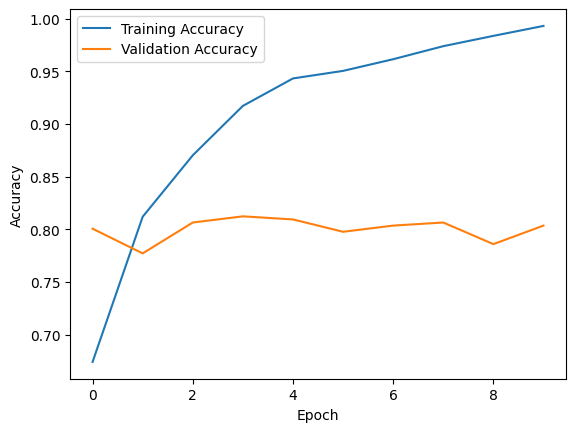

In [32]:
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### now we will tune it with different learning rate, we can try different learning rate to see how our model performs on different rate

In [39]:
def make_model(learning_rate):
  base_model = Xception(
      weights = 'imagenet',
      input_shape = (150,150,3),
      include_top = False
  )

  base_model.trainable = False

  inputs = keras.Input(shape=(150,150,3))
  base = base_model(inputs, training = False)

  vector = keras.layers.GlobalAveragePooling2D()(base)
  outputs = keras.layers.Dense(10)(vector)

  model = keras.Model(inputs, outputs)
  optimizer = keras.optimizers.Adam(learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits = True)

  model.compile(
      optimizer = optimizer,
      loss = loss,
      metrics = ["accuracy"],
  )

  return model

In [40]:
models = {}

for lr in [0.1, 0.01 , 0.001, 0.0001]:
  model = make_model(lr)
  model_historys = model.fit(train_ds, epochs=10, validation_data=val_ds)
  training_accuracy = model_historys.history['accuracy']
  validation_accuracy = model_historys.history['val_accuracy']

  final_training_accuracy = training_accuracy[-1]
  final_validation_accuracy = validation_accuracy[-1]

  models[lr] = {
        'model': model,
        'final_training_accuracy': final_training_accuracy,
        'final_validation_accuracy': final_validation_accuracy
    }

Epoch 1/10
96/96 [==============================] - 12s 92ms/step - loss: 10.4779 - accuracy: 0.6457 - val_loss: 10.2718 - val_accuracy: 0.6364
Epoch 2/10
96/96 [==============================] - 8s 85ms/step - loss: 4.8404 - accuracy: 0.7761 - val_loss: 6.6745 - val_accuracy: 0.7654
Epoch 3/10
96/96 [==============================] - 9s 90ms/step - loss: 4.3247 - accuracy: 0.8158 - val_loss: 11.4494 - val_accuracy: 0.7243
Epoch 4/10
96/96 [==============================] - 8s 86ms/step - loss: 3.1392 - accuracy: 0.8628 - val_loss: 7.3332 - val_accuracy: 0.8065
Epoch 5/10
96/96 [==============================] - 8s 82ms/step - loss: 2.7578 - accuracy: 0.8778 - val_loss: 7.7556 - val_accuracy: 0.7947
Epoch 6/10
96/96 [==============================] - 9s 90ms/step - loss: 1.5714 - accuracy: 0.9133 - val_loss: 9.1986 - val_accuracy: 0.7595
Epoch 7/10
96/96 [==============================] - 9s 89ms/step - loss: 2.6193 - accuracy: 0.8905 - val_loss: 8.0709 - val_accuracy: 0.8094
Epoch 8/1

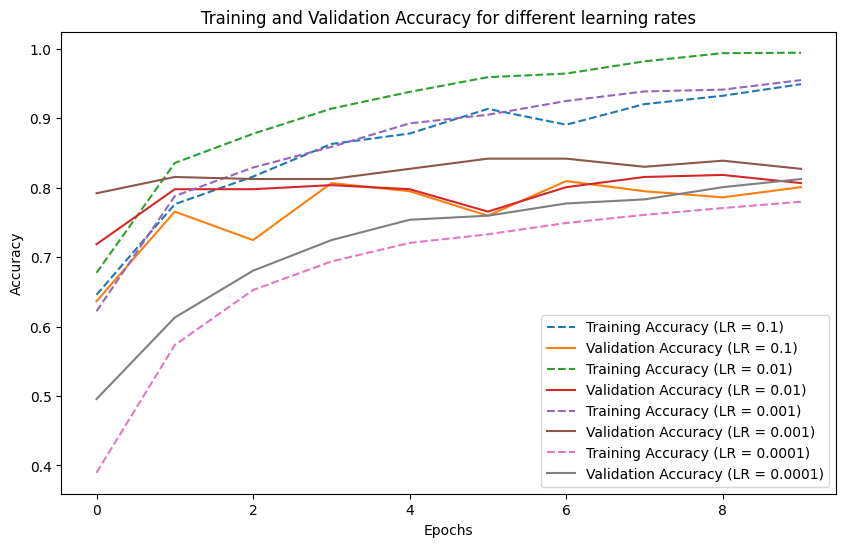

In [41]:
plt.figure(figsize = (10,6))

for lr , results in models.items():
  plt.plot(results['model'].history.history['accuracy'], label = f"Training Accuracy (LR = {lr})", linestyle = "dashed")
  plt.plot(results['model'].history.history['val_accuracy'],label = f"Validation Accuracy (LR = {lr})")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy for different learning rates")
plt.legend()
plt.show()

In [43]:
for lr , results in models.items():
  print(f"learning rate : {lr} , accuracy : {results['model'].history.history['accuracy'][-1]} , val_accuracy : {results['model'].history.history['val_accuracy'][-1]}")

learning rate : 0.1 , accuracy : 0.9488266110420227 , val_accuracy : 0.8005865216255188
learning rate : 0.01 , accuracy : 0.9941329956054688 , val_accuracy : 0.8064516186714172
learning rate : 0.001 , accuracy : 0.954693615436554 , val_accuracy : 0.8269794583320618
learning rate : 0.0001 , accuracy : 0.7796609997749329 , val_accuracy : 0.8123167157173157


HERE we can see that learning rate of 0.001 is much better for our model as it gives us a good accuracy and val_accuracy

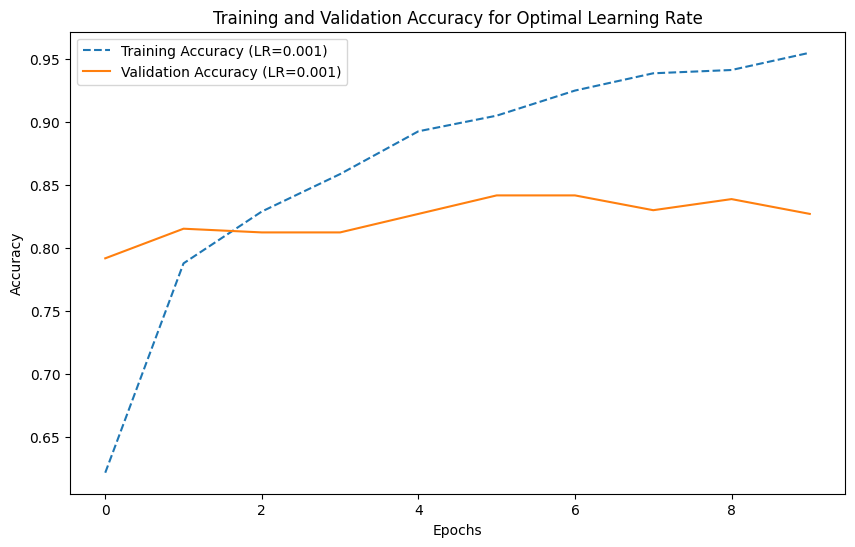

In [44]:
optimal_lr = 0.001

optimal_model = models[optimal_lr]['model']
optimal_model_history = optimal_model.history.history

plt.figure(figsize=(10, 6))

plt.plot(optimal_model_history['accuracy'], label=f'Training Accuracy (LR={optimal_lr})', linestyle='dashed')
plt.plot(optimal_model_history['val_accuracy'], label=f'Validation Accuracy (LR={optimal_lr})')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Optimal Learning Rate')
plt.legend()
plt.show()


In [45]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "xception_v1_{epoch:02d}_{val_accuracy:.3f}.",
    save_best_only = True,
    monitor = "val_accuracy"
)

In [46]:
model2 = make_model(learning_rate = 0.001)
model2.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds,
    callbacks = [checkpoint]
)

Epoch 1/10
96/96 [==============================] - 26s 237ms/step - loss: 1.0487 - accuracy: 0.6460 - val_loss: 0.7264 - val_accuracy: 0.7654
Epoch 2/10
96/96 [==============================] - 22s 230ms/step - loss: 0.6206 - accuracy: 0.7806 - val_loss: 0.6131 - val_accuracy: 0.8094
Epoch 3/10
96/96 [==============================] - 8s 87ms/step - loss: 0.5008 - accuracy: 0.8380 - val_loss: 0.6038 - val_accuracy: 0.8035
Epoch 4/10
96/96 [==============================] - 23s 246ms/step - loss: 0.4248 - accuracy: 0.8670 - val_loss: 0.5444 - val_accuracy: 0.8270
Epoch 5/10
96/96 [==============================] - 23s 237ms/step - loss: 0.3690 - accuracy: 0.8833 - val_loss: 0.5247 - val_accuracy: 0.8446
Epoch 6/10
96/96 [==============================] - 9s 92ms/step - loss: 0.3237 - accuracy: 0.9032 - val_loss: 0.5318 - val_accuracy: 0.8123
Epoch 7/10
96/96 [==============================] - 8s 86ms/step - loss: 0.2855 - accuracy: 0.9221 - val_loss: 0.5145 - val_accuracy: 0.8416
Epoch

HERE we are doing regularization by adding one dropout layer which helps us from overfitting , we have also added one inner layer with 100 neurons and relu activation function

In [48]:
def make_model(learning_rate, droprate):
  base_model = Xception(
      weights = 'imagenet',
      include_top = False,
      input_shape = (150, 150, 3)
  )

  base_model.trainable = False

  inputs = keras.Input(shape = (150,150,3))
  base = base_model(inputs, training = False)
  vector = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(100, activation = 'relu')(vector)
  drop = keras.layers.Dropout(0.2)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits = True)

  model.compile(
      optimizer = optimizer,
      loss = loss,
      metrics = ["accuracy"]
  )

  return model

In [53]:
model = make_model(0.001, 0.8)
history = model.fit(train_ds, epochs = 30, validation_data = val_ds, callbacks = [checkpoint])

Epoch 1/30
96/96 [==============================] - 12s 95ms/step - loss: 1.0592 - accuracy: 0.6421 - val_loss: 0.6740 - val_accuracy: 0.7801
Epoch 2/30
96/96 [==============================] - 8s 81ms/step - loss: 0.6015 - accuracy: 0.7898 - val_loss: 0.6300 - val_accuracy: 0.7889
Epoch 3/30
96/96 [==============================] - 8s 88ms/step - loss: 0.4670 - accuracy: 0.8413 - val_loss: 0.5753 - val_accuracy: 0.8182
Epoch 4/30
96/96 [==============================] - 8s 80ms/step - loss: 0.3591 - accuracy: 0.8784 - val_loss: 0.5476 - val_accuracy: 0.8094
Epoch 5/30
96/96 [==============================] - 8s 77ms/step - loss: 0.2781 - accuracy: 0.9133 - val_loss: 0.5671 - val_accuracy: 0.8065
Epoch 6/30
96/96 [==============================] - 8s 86ms/step - loss: 0.2331 - accuracy: 0.9257 - val_loss: 0.5528 - val_accuracy: 0.8035
Epoch 7/30
96/96 [==============================] - 8s 83ms/step - loss: 0.1774 - accuracy: 0.9505 - val_loss: 0.5737 - val_accuracy: 0.8240
Epoch 8/30
9

With no dropout, the model quickly memorizes the entire training dataset, and after 10 epochs
it becomes 99.9% accurate. With a dropout rate of 0.2, it needs more time to overfit the
training dataset, while for 0.5, it hasn’t reached the perfect accuracy even after 30 iterations.
By setting the rate to 0.8, we make it really difficult for the network to learn anything, so the
accuracy is low even on the training dataset.

In [ ]:
#HENCE DROPOUT RATE IS NOW 0.5 which will prevent overfitting

In [63]:
train_gen = ImageDataGenerator(
    shear_range = 10.0,
    zoom_range = 0.1,
    horizontal_flip = True,
    preprocessing_function = preprocess_input
)

In [64]:
train_ds = train_gen.flow_from_directory(
 "clothing-dataset-small/train",
 target_size=(150, 150),
 batch_size=32,
)

Found 3068 images belonging to 10 classes.


In [65]:
validation_gen = ImageDataGenerator(
 preprocessing_function=preprocess_input
)
val_ds = validation_gen.flow_from_directory(
 "clothing-dataset-small/validation",
 target_size=image_size,
 batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [66]:
def make_model_large(learning_rate, droprate):
  base_model = Xception(
      weights = 'imagenet',
      include_top = False,
      input_shape = (299, 299, 3)
  )

  base_model.trainable = False

  inputs = keras.Input(shape = (299, 299,3))
  base = base_model(inputs, training = False)
  vector = keras.layers.GlobalAveragePooling2D()(base)

  inner = keras.layers.Dense(100, activation = 'relu')(vector)
  drop = keras.layers.Dropout(0.2)(inner)
  outputs = keras.layers.Dense(10)(drop)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate)
  loss = keras.losses.CategoricalCrossentropy(from_logits = True)

  model.compile(
      optimizer = optimizer,
      loss = loss,
      metrics = ["accuracy"]
  )

  return model

In [67]:
earlystop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [68]:
model = make_model(learning_rate=0.001, droprate=0.5)
model_history_large = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks = [checkpoint, earlystop])

Epoch 1/50
96/96 [==============================] - 28s 256ms/step - loss: 1.1164 - accuracy: 0.6164 - val_loss: 0.6316 - val_accuracy: 0.7977
Epoch 2/50
96/96 [==============================] - 24s 248ms/step - loss: 0.7218 - accuracy: 0.7598 - val_loss: 0.5772 - val_accuracy: 0.8094
Epoch 3/50
96/96 [==============================] - 23s 241ms/step - loss: 0.6054 - accuracy: 0.7930 - val_loss: 0.5722 - val_accuracy: 0.8065
Epoch 4/50
96/96 [==============================] - 23s 242ms/step - loss: 0.5330 - accuracy: 0.8184 - val_loss: 0.5694 - val_accuracy: 0.8065
Epoch 5/50
96/96 [==============================] - 24s 249ms/step - loss: 0.4689 - accuracy: 0.8305 - val_loss: 0.5368 - val_accuracy: 0.8446
Epoch 6/50
96/96 [==============================] - 24s 249ms/step - loss: 0.4189 - accuracy: 0.8556 - val_loss: 0.5630 - val_accuracy: 0.8182
Epoch 7/50
96/96 [==============================] - 24s 248ms/step - loss: 0.3794 - accuracy: 0.8647 - val_loss: 0.5505 - val_accuracy: 0.8240

In [72]:
model = keras.models.load_model('xception_v1_21_0.848.')

In [75]:
test_gen = ImageDataGenerator(
 preprocessing_function=preprocess_input
)
test_ds = test_gen.flow_from_directory(
 "clothing-dataset-small/test",
 shuffle=False,
 target_size=(150, 150), #A
 batch_size=32,
)

Found 372 images belonging to 10 classes.


In [76]:
model.evaluate(test_ds)

12/12 [==============================] - 3s 217ms/step - loss: 0.7639 - accuracy: 0.7930


[0.7639178037643433, 0.7930107712745667]

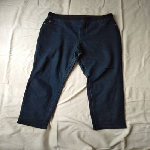

In [79]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(150, 150))
img

In [80]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [81]:
pred = model.predict(X)


1/1 [==============================] - 1s 1s/step


In [82]:
pred[0]

array([-4.366367 , -7.4244   , -2.8542602, -2.2646747, 12.959241 ,
       -5.307102 , -4.9778647,  1.3762358, -8.127768 , -8.408343 ],
      dtype=float32)

In [83]:
pred[0].argmax()

4

In [85]:
labels = {
 0: 'dress',
 1: 'hat',
 2: 'longsleeve',
 3: 'outwear',
 4: 'pants',
 5: 'shirt',
 6: 'shoes',
 7: 'shorts',
 8: 'skirt',
 9: 't-shirt'
}

In [86]:
labels[pred[0].argmax()]

'pants'

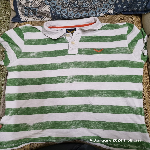

In [88]:
img = load_img("tshirt.jpeg", target_size=(150, 150))
img

In [89]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

pred = model.predict(X)
labels[pred[0].argmax()]

1/1 [==============================] - 0s 38ms/step


't-shirt'

In [ ]:
dropout_rates = [0.0, 0.2, 0.5, 0.8]


models = {}


for dropout_rate in dropout_rates:
    model = make_model(dropout_rate)
    checkpoint = keras.callbacks.ModelCheckpoint(f'xception_v1_{dropout_rate}.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])


    max_val_accuracy_epoch = np.argmax(history.history['val_accuracy']) + 1
    max_val_accuracy = max(history.history['val_accuracy'])


    models[dropout_rate] = {'model': model, 'max_val_accuracy': max_val_accuracy, 'max_val_accuracy_epoch': max_val_accuracy_epoch}


best_dropout_rate = max(models, key=lambda x: models[x]['max_val_accuracy'])


best_model = models[best_dropout_rate]['model']

print(f'Best Dropout Rate: {best_dropout_rate}')
best_model.summary()